**使用[photutils](https://photutils.readthedocs.io/en/stable/index.html)构建effective PSF**  
@Author: Ray  
@Time: 2022.09.13  
@cite: https://photutils.readthedocs.io/en/stable/epsf.html

*什么是effective PSF?*  
* 仪器的PSF受很多因素影响，通常是很难去建模的，即理论建立的PSF模型通常表现不是很好。
* 而通过对视场中的恒星进行精确测光而创建的PSF模型，被称为是effective PSF，是一种经验的PSF。
* ePSF相对于仪器像素通常是过采样的

In [77]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rc('font',family='Times New Roman')
from astropy.visualization import simple_norm
import numpy as np

## 产生实验用图

加载图像

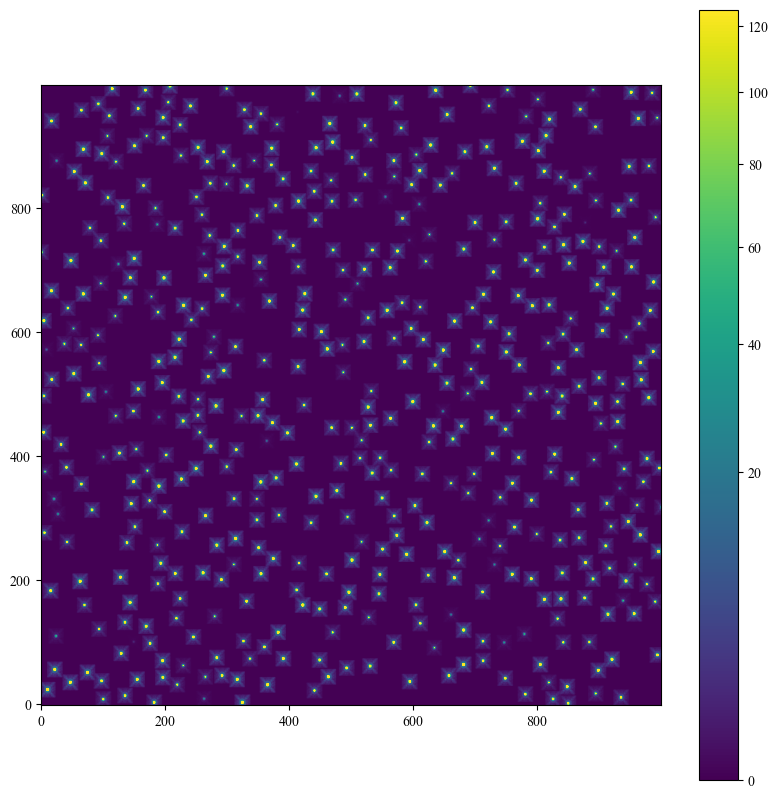

In [78]:
from photutils.datasets import load_simulated_hst_star_image
hdu = load_simulated_hst_star_image()  # 可能需要翻墙，不然会报错
data = hdu.data
hdu.header

# 查看图像
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()


向图像中添加背景噪声

In [79]:
from photutils.datasets import make_noise_image
data += make_noise_image(
    data.shape, 
    distribution='gaussian',
    mean=10., stddev=5., seed=123
    )  

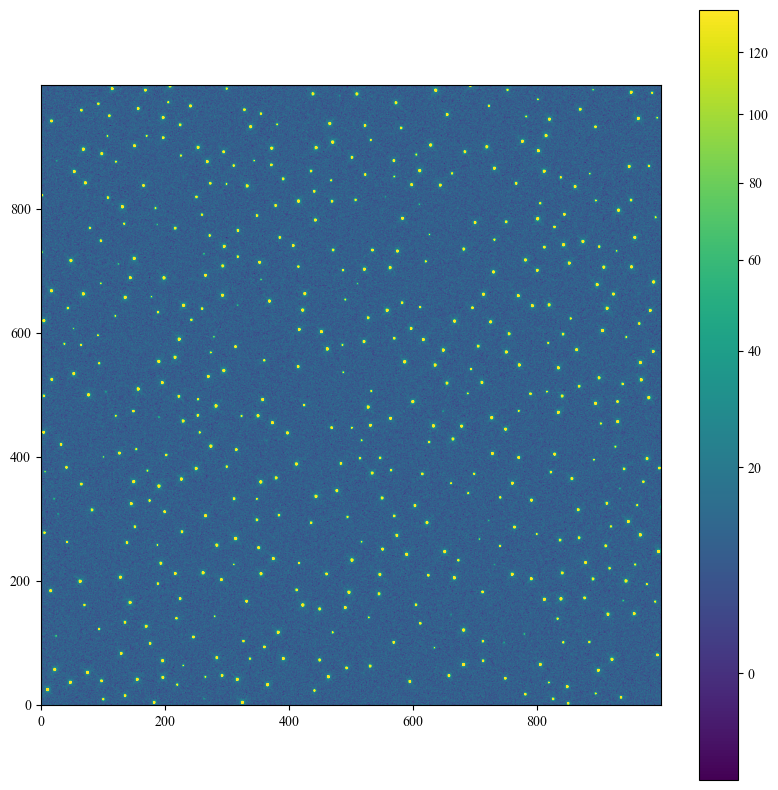

In [80]:
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

## 制作恒星的cutouts

寻星

In [81]:
from photutils.detection import find_peaks
peaks_tbl = find_peaks(data, threshold=500.) 
print(peaks_tbl)

x_peak y_peak     peak_value    
------ ------ ------------------
   849      2 1076.7025586493498
   182      4 1709.5671124156065
   324      4 3006.0085694164686
   100      9 1142.9915196714978
   824      9 1302.8604257696884
   934     12  891.5304912385355
   135     15 1491.0007573496678
   780     17  965.0112131067682
   893     18  593.8860478215643
   440     23 1235.3081002897825
   ...    ...                ...
   437    985 1980.3149342432641
   508    985 2626.4065259269864
   984    987  738.9913599619076
   950    988  2696.248572204324
   168    991 1693.8834550308766
   635    991 3607.8908893729786
   751    992  801.2383353835909
   114    994  1595.280405891018
   299    994   648.185391784225
   207    998 2810.6503206394596
   691    999 2611.0463913552317
Length = 431 rows


In [82]:
size = 25  # 制作25x25的cutout
hsize = (size - 1)/2

x = peaks_tbl['x_peak']
y = peaks_tbl['y_peak']
selected = (
    (x>hsize) & (x<(data.shape[1]-1-hsize)) & (y>hsize) & (y<(data.shape[0]-1-hsize))
    )
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[selected]
stars_tbl['y'] = y[selected]
print(stars_tbl)

 x   y 
--- ---
135  15
780  17
893  18
440  23
847  29
219  32
364  32
 47  36
817  36
593  37
... ...
354 953
 65 959
327 960
868 960
156 962
240 966
721 966
 92 969
571 971
437 985
508 985
Length = 404 rows


背景扣除

In [83]:
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
data -= median_val  
data

array([[-5.29487203, -2.18819854,  6.09036102, ...,  1.50402391,
        -5.66560313,  0.84631357],
       [ 5.31598478, -8.90979449,  0.61717343, ..., -6.98861959,
         5.84072573,  5.74513242],
       [-2.2706072 ,  7.17764307, -3.28222902, ...,  0.10459687,
         1.74792869, -5.93255573],
       ...,
       [ 0.36891809,  0.65036711, -3.113536  , ...,  0.41051452,
         3.69136689, -3.48413345],
       [-0.70563918, -1.36531692,  5.41295092, ..., -7.74885014,
         0.52998879,  0.56774636],
       [ 0.32947169, -6.81550815,  2.94529496, ...,  0.15696621,
         2.45174828,  0.68772825]])

提取可用的恒星

In [84]:

from astropy.nddata import NDData
nddata = NDData(data=data)

from photutils.psf import extract_stars
stars = extract_stars(data=nddata, catalogs=stars_tbl, size=size)

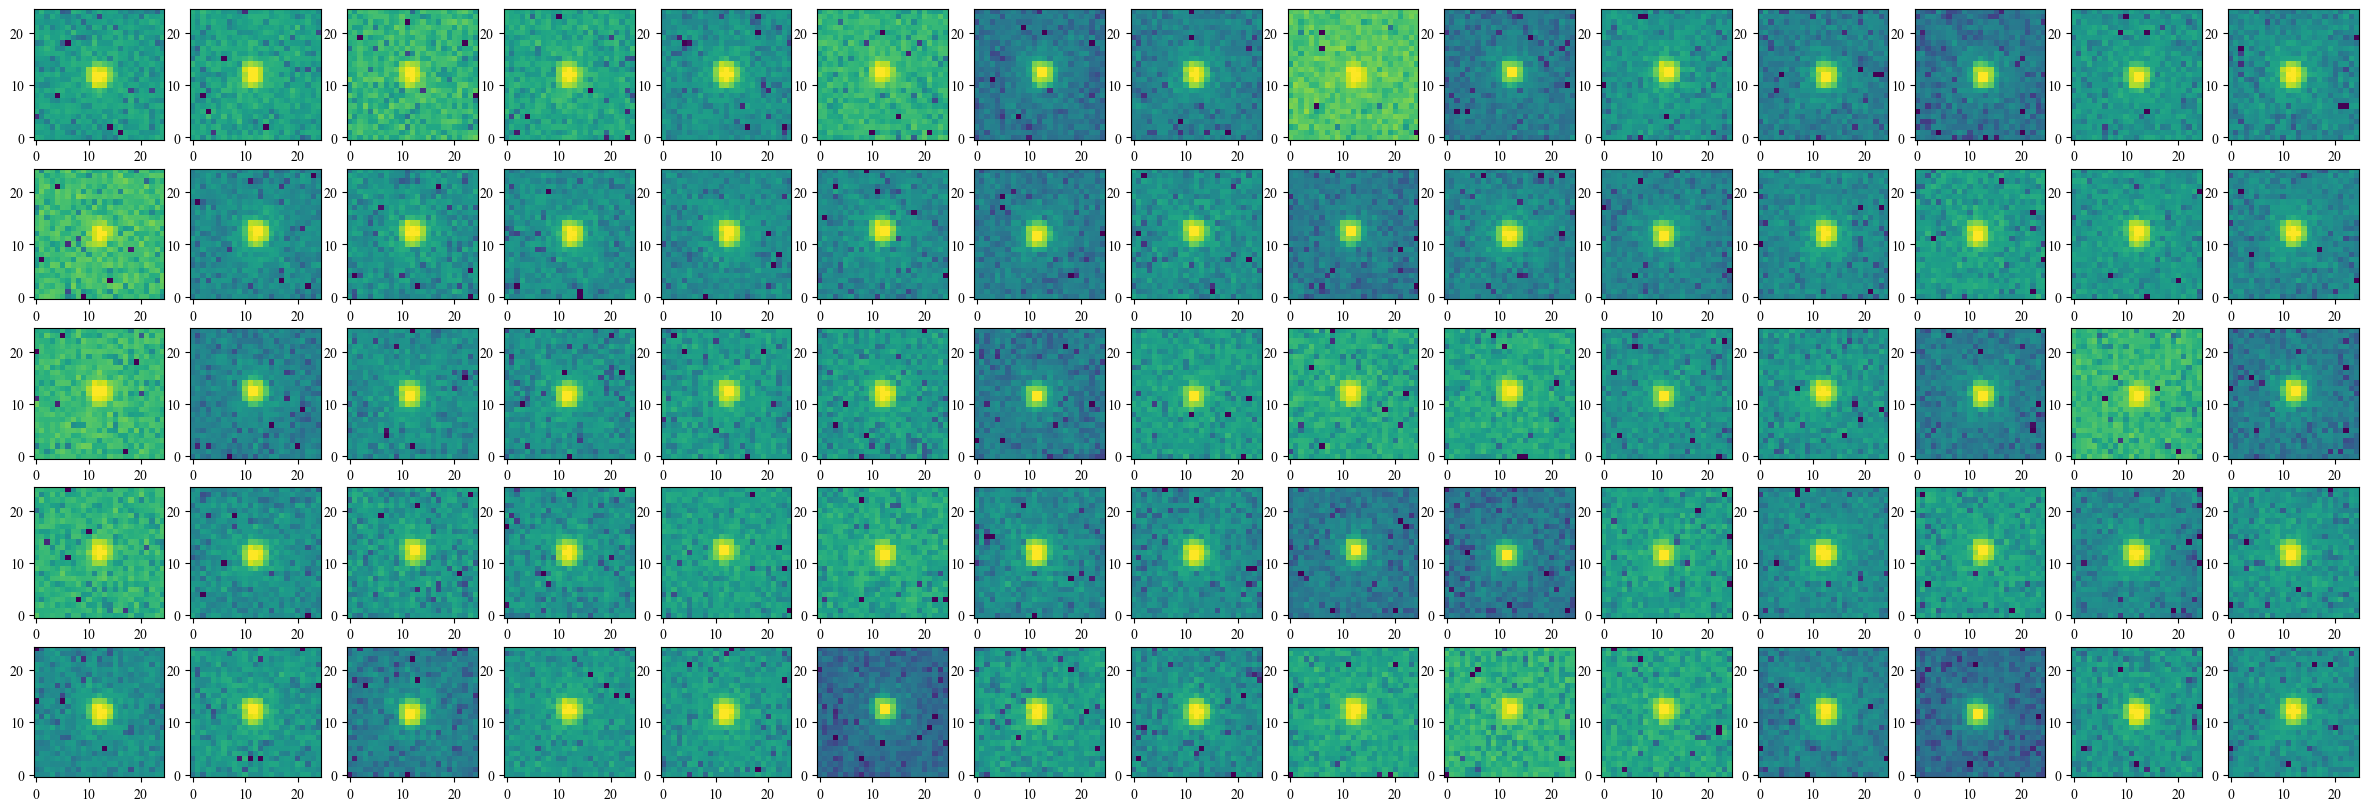

In [85]:
# 查看恒星的cutouts; 恒星一共404了，查看其中一部分的图像
nrows = 5
ncols = 15
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows), squeeze=True)
ax = ax.ravel()

for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

## 构建ePSF

In [86]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(
    oversampling=4, #过采样因子
    maxiters=3, 
    progress_bar=True  # 显示迭代进度
    )  
epsf, fitted_stars = epsf_builder(stars) 

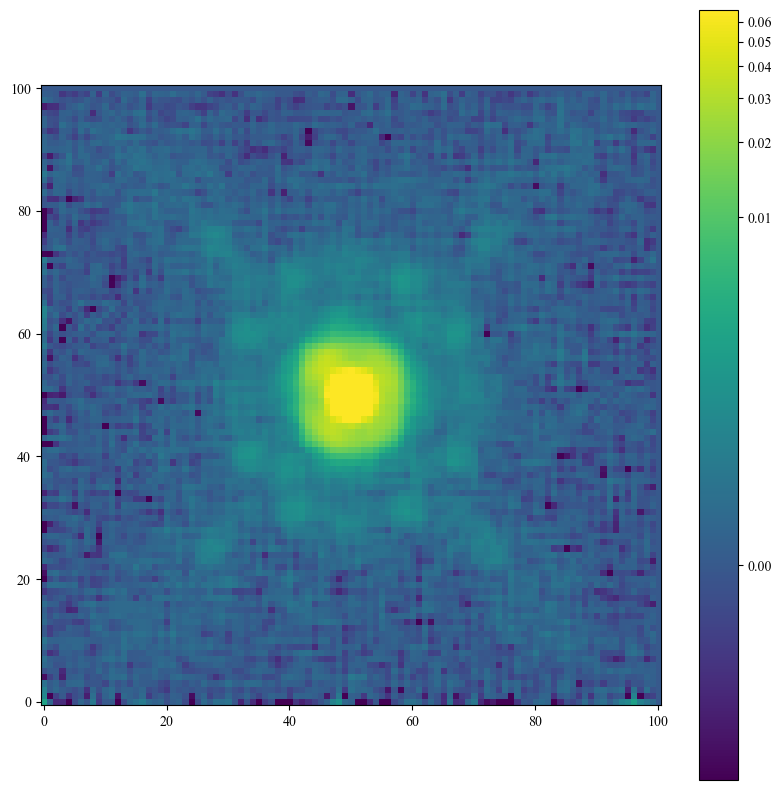

In [87]:
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()